In [1]:
import pandas as pd
import numpy as np
import arxiv
import os
import networkx as nx
import itertools

In [2]:
client=arxiv.Client()

In [51]:
search = arxiv.Search(
  query = "misinformation",
  max_results = 100000,
  sort_by = arxiv.SortCriterion.SubmittedDate
)

In [52]:
results=client.results(search)

In [5]:
all_results = list(results)

In [48]:
len(all_results)

1570

In [6]:
all_results[0]

arxiv.Result(entry_id='http://arxiv.org/abs/2411.01794v1', updated=datetime.datetime(2024, 11, 4, 4, 34, 29, tzinfo=datetime.timezone.utc), published=datetime.datetime(2024, 11, 4, 4, 34, 29, tzinfo=datetime.timezone.utc), title='Revisiting Game-Theoretic Control in Socio-Technical Networks: Emerging Design Frameworks and Contemporary Applications', authors=[arxiv.Result.Author('Quanyan Zhu'), arxiv.Result.Author('Tamer Başar')], summary='Socio-technical networks represent emerging cyber-physical infrastructures\nthat are tightly interwoven with human networks. The coupling between human and\ntechnical networks presents significant challenges in managing, controlling,\nand securing these complex, interdependent systems. This paper investigates\ngame-theoretic frameworks for the design and control of socio-technical\nnetworks, with a focus on critical applications such as misinformation\nmanagement, infrastructure optimization, and resilience in socio-cyber-physical\nsystems (SCPS). Cor

In [7]:
authorship=[]
for authors in all_results:
    author_list=[]
    for i in authors.authors:
        author_list.append(i.name)
    authorship.append(author_list)

In [8]:
authorship[0]

['Quanyan Zhu', 'Tamer Başar']

In [45]:
abstract=[]
for abstracts in all_results:
    abstract.append(abstracts.summary)

In [47]:
len(abstract)

1570

In [9]:
G=nx.Graph()

In [10]:
edges=[]
for val in authorship:
    edges.extend(list(itertools.combinations(val, 2)))

In [11]:
G.add_edges_from(edges)

In [12]:
len(list(G.nodes))

4863

In [28]:
sorted(nx.degree_centrality(G).items(), key=lambda x:x[1], reverse=True)[:5]

[('Preslav Nakov', 0.051245551601423495),
 ('Iason Gabriel', 0.049110320284697515),
 ('Lisa Anne Hendricks', 0.049110320284697515),
 ('Sasha Brown', 0.049110320284697515),
 ('Conor Griffin', 0.049110320284697515)]

In [25]:
nx.set_node_attributes(G, nx.degree_centrality(G), 'degree')

In [14]:
average_degree_centrality = np.mean(list(nx.degree_centrality(G).values()))

In [15]:
nodes_to_remove = [node for node, centrality in nx.degree_centrality(G).items() if centrality < average_degree_centrality]
G.remove_nodes_from(nodes_to_remove)

In [21]:
G.nodes

NodeView(('Wei Zhang', 'Luca Luceri', 'Emilio Ferrara', 'Rhett Hanscom', 'Qin Lv', 'Shivakant Mishra', 'Damiano Spina', 'Victoria Benjamin', 'Emily Braca', 'Israel Carter', 'Hafsa Kanchwala', 'Nava Khojasteh', 'Charly Landow', 'Yi Luo', 'Caroline Ma', 'Anna Magarelli', 'Rachel Mirin', 'Avery Moyer', 'Kayla Simpson', 'Amelia Skawinski', 'Thomas Heverin', 'Huzaifa Pardawala', 'Siddhant Sukhani', 'Agam Shah', 'Veer Kejriwal', 'Abhishek Pillai', 'Rohan Bhasin', 'Andrew DiBiasio', 'Tarun Mandapati', 'Dhruv Adha', 'Sudheer Chava', 'Philip Torr', 'John Collomosse', 'Yuxia Wang', 'Kevin Zhu', 'Sander van der Linden', 'Yuhan Liu', 'Tanmay Parekh', 'Jeffrey Kwan', 'Jiarui Yu', 'Sparsh Johri', 'Hyosang Ahn', 'Sreya Muppalla', 'Kai-Wei Chang', 'Wei Wang', 'Nanyun Peng', 'Laks V. S. Lakshmanan', 'Miao Yu', 'Shilong Wang', 'Guibin Zhang', 'Junyuan Mao', 'Chenlong Yin', 'Qijiong Liu', 'Qingsong Wen', 'Kun Wang', 'Yang Wang', 'Ponnurangam Kumaraguru', 'Syed Ishtiaque Ahmed', 'Owen Cook', 'Charlie Grim

In [16]:
len(list(G.nodes()))

1406

In [18]:
pos=nx.kamada_kawai_layout(G)

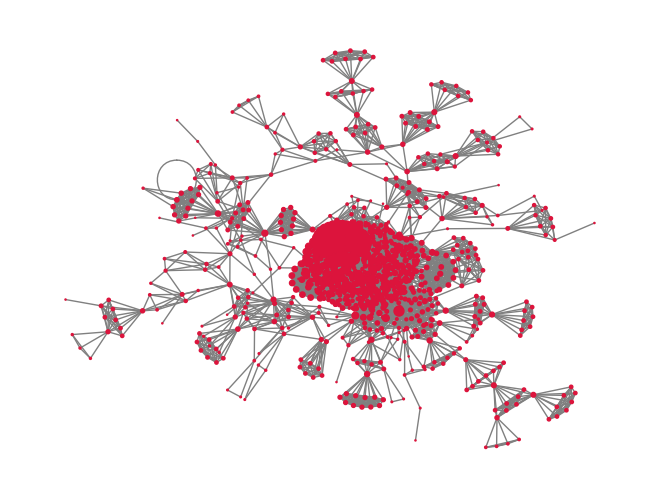

In [42]:
degree=nx.get_node_attributes(G, 'degree')
node_size=[v * 1000 for v in degree.values()]  
nx.draw(G, pos=pos, node_size=node_size, node_color='crimson', edge_color='grey')#, with_labels=True)

In [26]:
G.nodes['Preslav Nakov']

{'degree': 0.051245551601423495}